# Photometry + Gaia Proper Motions

In this notebook I will examine the distribution of proper motions among our stellar sample, with particular interest in high-velocity stars. Data regarding proper motion is from [Gaia Data Release 2](https://www.cosmos.esa.int/web/gaia/dr2), and photometric data is as discussed previously (GALEX NUV + Braun V).

In [1]:
# Import

# Standard
import numpy as np
import matplotlib.pyplot as plt

# Ancillary
import smc
import scipy.stats as stats
%config InlineBackend.figure_format = "retina"

## Define Functions for Plotting

In [2]:
def proper_motion_spatial_plot(data_type, pm, x, y, num_bins, color_max, color_map, s_coefficient):
    plt.figure(figsize=(18,5.5))

    plt.subplot(131)
    num_bins = num_bins
    cm = plt.cm.get_cmap(color_map)
    color_max = color_max

    n, bins, patches = plt.hist(pm, num_bins, normed=True, log=True, label = "Gaia proper motions")
    bin_centers = 0.5*(bins[:-1]+bins[1:])
    col = bin_centers[bin_centers <= color_max] - min(bin_centers[bin_centers <= color_max])
    col /= max(col)
    ones = np.ones(len(bin_centers) - len(col))
    color_values = np.concatenate((col, ones), axis=None)

    for c, p in zip(color_values, patches):
        plt.setp(p, 'facecolor', cm(c))
    
    if data_type == 'phot':
        plt.title("Proper Motions for Photometric Sample")
    elif data_type == 'spec':
        plt.title("Proper Motions for Photometric + Spectroscopic Sample")
    
    plt.xlabel("Proper Motion [mas / year]")
    plt.ylabel("log ( Normalized Frequency )")
    plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., prop={'size':10})


    plt.subplot(132)
    smc.plot_field(ra, dec, True)
    plt.scatter(x, y, c = pm, label="Gaia proper motions", \
            vmin = min(pm), vmax = color_max, s=np.sqrt(s_coefficient*pm), marker="o", cmap = cm)
    smc.plt_spatial("Spatial Plot", True)
    
    plt.subplot(133)
    smc.plot_field(nuv_v, nuv, True)
    plt.scatter(gaia_nuv_v, gaia_nuv, c = pm, label="Gaia proper motions", \
            vmin = min(pm), vmax = color_max, s=np.sqrt(s_coefficient*pm), marker="o", cmap = cm)
    smc.plt_nuv("(NUV-V)o vs. NUVo", True)

    plt.show()

## Foreground-corrected photometry

In [3]:
# Import photometric data

# No high proper motion stars
data = np.genfromtxt('../data/foreground_corrected_photometry', dtype=None, names=True)

# With high proper motion stars
# data = np.genfromtxt('../data/foreground_corrected_photometry_with_high_proper_motions', dtype=None, names=True)

id_number, ra, dec, nuv_v, nuv, b_v, v = data['id'], data['ra'], data['dec'], \
data['nuv_v'], data['nuv'], data['b_v'], data['v']

print("There are {} field stars in our photometric sample".format(len(nuv)))

There are 1104 field stars in our photometric sample


## Defining variables from photometric + Gaia DR2 stellar sample

In [4]:
# Import photometric + astrometric data

# No high proper motion stars
gaia = np.genfromtxt('../data/foreground_corrected_photometry_gaia_full', names=True)

# With high proper motion stars
# gaia = np.genfromtxt('../data/foreground_corrected_photometry_with_high_proper_motion_gaia_full', names=True)

# Photometric values from Fulmer et. al., matched with proper motions from Gaia DR2
gaia_id, gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv, pmra, pmra_error, pmdec, pmdec_error = \
gaia['id'], gaia['ra_1'], gaia['dec_1'], gaia['nuv_v'], gaia['nuv'], gaia['pmra'], \
gaia['pmra_error'], gaia['pmdec'], gaia['pmdec_error']

# Construct proper motion vectors
pm_vector = np.sqrt(pmra**2 + pmdec**2)
squared_pmra = np.abs(pmra) * np.sqrt(2 * (pmra_error / pmra)**2)
squared_pmdec = np.abs(pmdec) * np.sqrt(2 * (pmdec_error / pmdec)**2)
added = np.sqrt(squared_pmra**2 + squared_pmdec**2)
sqrted = 0.5 * (pmra**2 + pmdec**2)**(-0.5) * added
pm_vector_error = sqrted

# Create quality parameter
quality_parameter = (pm_vector_error <= 1.0) & (gaia['astrometric_primary_flag'] == 0)# & (pm_vector < 5)

gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv = \
gaia_ra[quality_parameter], gaia_dec[quality_parameter], gaia_nuv_v[quality_parameter], \
gaia_nuv[quality_parameter]

pmra, pmra_error, pmdec, pmdec_error = \
pmra[quality_parameter], pmra_error[quality_parameter], pmdec[quality_parameter], \
pmdec_error[quality_parameter]

pm_vector, pm_vector_error = \
pm_vector[quality_parameter], pm_vector_error[quality_parameter]

# Final stellar count
print("There are {} field stars in our photometric + gaia sample after quality checks".format(len(gaia_nuv)))

There are 1029 field stars in our photometric + gaia sample after quality checks


/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal


## Plotting proper motion histogram, spatial plot, and color-magnitude diagram

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


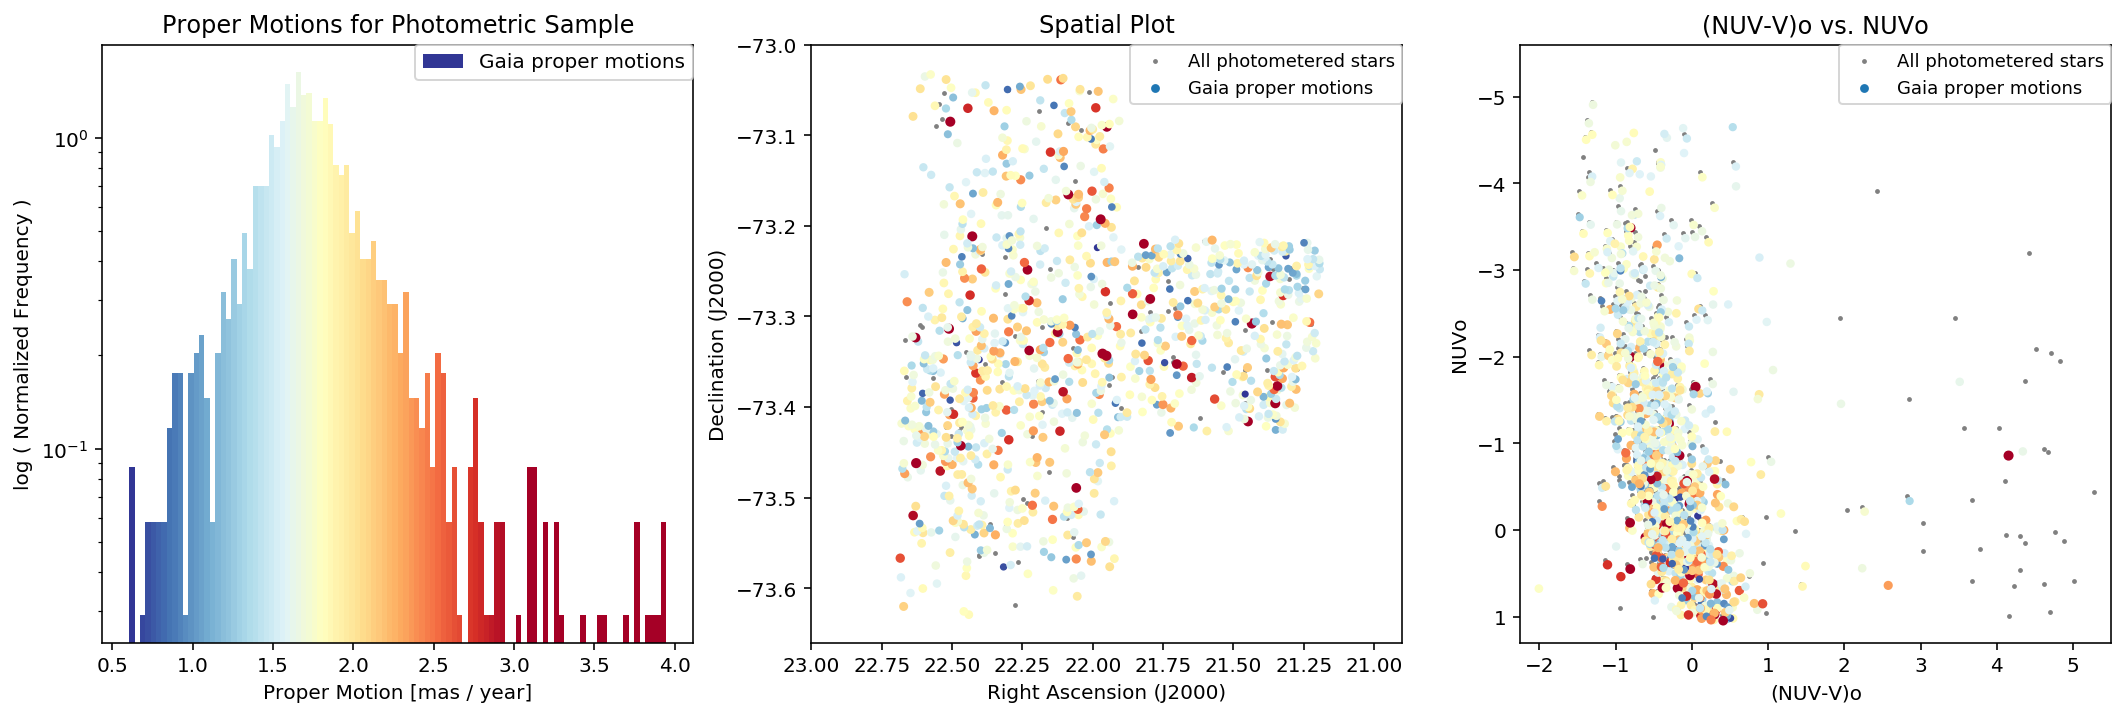

In [5]:
# Plot histogram of stellar proper motions

# No high proper motion stars
proper_motion_spatial_plot('phot', pm_vector, gaia_ra, gaia_dec, 100, 3, 'RdYlBu_r', 70)

# With high proper motion stars
# proper_motion_spatial_plot('phot', pm_vector, gaia_ra, gaia_dec, 100, 6, 'RdYlBu_r', 70)

In [6]:
# Identify high-proper-motion stars, most likely not in the SMC
high_proper_motion = (pm_vector >= 4)

high_proper_motion_coordinates = np.c_[gaia_ra[high_proper_motion], gaia_dec[high_proper_motion]]
print("There are {} stars with abnormally high proper motions [>= 4 mas/yr] which we therefore suspect \
are not located in the SMC.".format(len(high_proper_motion_coordinates)))

np.savetxt('../data/high_proper_motion_coordinates_phot', high_proper_motion_coordinates, \
           delimiter=" ", fmt="%s", header='ra dec')

There are 0 stars with abnormally high proper motions [>= 4 mas/yr] which we therefore suspect are not located in the SMC.


## Defining variables from photometric + spectroscopic + Gaia DR2 stellar sample

In [7]:
# Import data

# No high proper motion stars
gaia = np.genfromtxt('../data/foreground_corrected_spec_phot_gaia_full', dtype=None, names=True)

# With high proper motion stars
# gaia = np.genfromtxt('../data/foreground_corrected_spec_phot_with_high_proper_motion_gaia_full', dtype=None, names=True)

valid_proper_motion = (gaia['pmra'] != b'""')

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  after removing the cwd from sys.path.


In [8]:
# Photometric values from Fulmer et. al., matched with proper motions from Gaia DR2
gaia_id, gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv, pmra, pmra_error, pmdec, pmdec_error = \
gaia['id_1'][valid_proper_motion], gaia['ra'][valid_proper_motion], gaia['dec'][valid_proper_motion], \
gaia['nuv_v'][valid_proper_motion], gaia['nuv'][valid_proper_motion], \
np.asarray([ float(x) for x in gaia['pmra'][valid_proper_motion] ]), \
np.asarray([ float(x) for x in gaia['pmra_error'][valid_proper_motion] ]), \
np.asarray([ float(x) for x in gaia['pmdec'][valid_proper_motion] ]), \
np.asarray([ float(x) for x in gaia['pmdec_error'][valid_proper_motion] ])

spectraltype = gaia['SpectralType'][valid_proper_motion]
Tstar = gaia['T∗'][valid_proper_motion]
logL = gaia['logL'][valid_proper_motion]

# Construct proper motion vectors
pm_vector = np.sqrt(pmra**2 + pmdec**2)
squared_pmra = np.abs(pmra) * np.sqrt(2 * (pmra_error / pmra)**2)
squared_pmdec = np.abs(pmdec) * np.sqrt(2 * (pmdec_error / pmdec)**2)
added = np.sqrt(squared_pmra**2 + squared_pmdec**2)
sqrted = 0.5 * (pmra**2 + pmdec**2)**(-0.5) * added
pm_vector_error = sqrted

# Create quality parameter
quality_parameter = (pm_vector_error <= 1.0) & (gaia['astrometric_primary_flag'][valid_proper_motion] == 0)

gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv = \
gaia_ra[quality_parameter], gaia_dec[quality_parameter], gaia_nuv_v[quality_parameter], gaia_nuv[quality_parameter]

pmra, pmra_error, pmdec, pmdec_error = \
pmra[quality_parameter], pmra_error[quality_parameter], pmdec[quality_parameter], pmdec_error[quality_parameter]

pm_vector, pm_vector_error = \
pm_vector[quality_parameter], pm_vector_error[quality_parameter]

# Final stellar count
print("There are {} field stars in our photometric + spectroscopic + gaia sample".format(len(gaia_nuv)))

There are 106 field stars in our photometric + spectroscopic + gaia sample


## Plotting proper motion histogram, spatial plot, and color-magnitude diagram

/Users/leahfulmer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


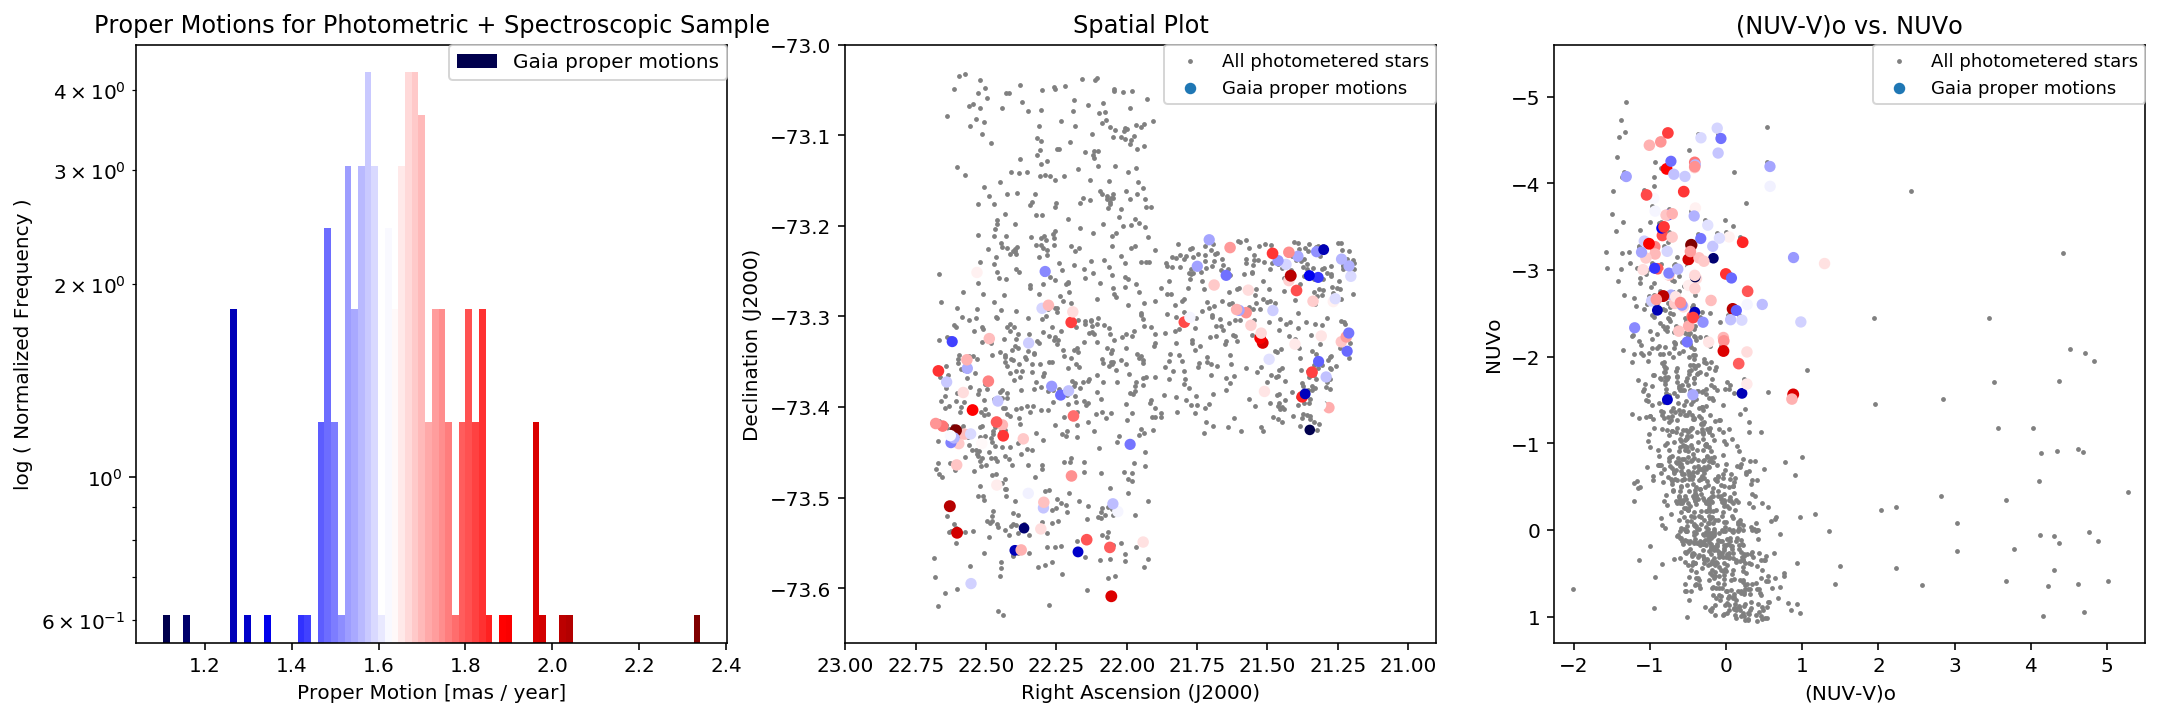

In [9]:
# No high proper motion stars
proper_motion_spatial_plot('spec', pm_vector, gaia_ra, gaia_dec, 80, 2.15, 'seismic', 300)

# With high proper motion stars
# proper_motion_spatial_plot('spec', pm_vector, gaia_ra, gaia_dec, 80, 2.4, 'seismic', 300)

## Matching spectral types to proper motions

In [10]:
# Organize data by spectral type
indices_B , indices_Be, indices_O, indices_Of = [], [], [], []

for i in range(len(spectraltype)):
    if (spectraltype[i][0:1] == b'B') and (b'e' not in spectraltype[i]):
        indices_B.append(i)
    elif (spectraltype[i][0:1] == b'B') and (b'e' in spectraltype[i]):
        indices_Be.append(i)
    elif (spectraltype[i][0:1] == b'O') and (b'f' not in spectraltype[i]):
        indices_O.append(i)
    elif (spectraltype[i][0:1] == b'O') and (b'f' in spectraltype[i]):
        indices_Of.append(i)

B = smc.organize_spectypes(indices_B, gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv, Tstar, logL, pm = pm_vector)
Be = smc.organize_spectypes(indices_Be, gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv, Tstar, logL, pm = pm_vector)
O = smc.organize_spectypes(indices_O, gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv, Tstar, logL, pm = pm_vector)
Of = smc.organize_spectypes(indices_Of, gaia_ra, gaia_dec, gaia_nuv_v, gaia_nuv, Tstar, logL, pm = pm_vector)

In [11]:
high_proper_motions_spectype = spectraltype[np.where(pm_vector >= 2.0)]

print('The spectral types of stars with proper motions greater than or equal to 2 mas/yr are {}. \
The proper motions of all O stars in this region are {}, and {} mas/yr.'.format(high_proper_motions_spectype, \
                                                         O.pm_vector, Of.pm_vector))

The spectral types of stars with proper motions greater than or equal to 2 mas/yr are [b'B0.5V' b'B2.5(IV)e' b'B1(V)e']. The proper motions of all O stars in this region are [1.70517623 1.82352529 1.48093175], and [1.73471463] mas/yr.
